# Gentrification in New York City
By: Adrian Herrmann

## Goals
In this notebook I will be analyzing the construction permits and property values in different neighborhoods to identify which areas have seen an increase in cost as a result of a higher number of alterations/new buildings.

The main idea is that areas with a greater number of alterations drive up the property value, turning the area more expensive and unsuitable for low income families.

## Data
I will be using the DOB Permit data found here:<br>
https://data.cityofnewyork.us/Housing-Development/DOB-Permit-Issuance/ipu4-2q9a

as well as the property annualized sale found here:<br>
https://www1.nyc.gov/site/finance/taxes/property-annualized-sales-update.page

together with the rolling sales found here:<br>
https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page

NOTE: Yearly Census data would be helpful but I was not able to find any, especially not by zip code as generally census data is released every decade. Also, the property sales are provided by NYC Open Data and may not be entirely indicative of the median property price but will do just fine for the purpose of this project. Any other historical rent data sets are all premium subscription based.

In [1]:
import pandas as pd
import geopandas as gpd
from descartes import PolygonPatch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import os

## Data Retrieval and Cleaning
### The Sales Data
First I want to read in the sales data which is only available individually each year for each borough, making 5 x 16 = 80 separate csv files. I'll have to combine each file into a single DataFrame.
<br><br>
I will need to keep a couple of things in mind here:
1. There are a few lines preceding the data with some information that will need to be ignored (the number of these lines varies per csv file).
2. The 'SALE PRICE' feature goes by 3 slightly different strings. I will need to make sure all 'SALE PRICE' features are put into the same column.

In [2]:
path = 'data/house_sales/'

house_sales = pd.DataFrame()
for filename in os.listdir(path):
    with open(os.path.join(path, filename)) as sales:
        # Set the dtype as string by default otherwise read_csv would take a long time guessing dtypes
        sales_df = pd.read_csv(sales, dtype=np.string_)

        # Remove descriptions
        i = 0
        while 'BOROUGH' not in sales_df.iloc[0][0]:
            sales_df.drop(i, inplace=True)
            i += 1

        sales_df.columns = [title.strip('\n') for title in sales_df.iloc[0].values]
        sales_df.drop(i, inplace=True)
        
        # Sale price column had different spacing in some csv files
        if ' SALE PRICE ' in sales_df.columns:
            sales_df.rename({' SALE PRICE ':'SALE PRICE'}, axis='columns', inplace=True)
    
        if ' SALE PRICE\n ' in sales_df.columns:
            sales_df.rename({' SALE PRICE\n ':'SALE PRICE'}, axis='columns', inplace=True)
        
        house_sales = pd.concat([house_sales, sales_df], sort=False).reset_index(drop=True)

Let's only keep the features that are interesting and could come to use.
<br>
NOTE: The tax class will be the simplest and best indicator to distinguish between a residential vs. commercial sale.

In [3]:
house_sales = house_sales[['BOROUGH', 'NEIGHBORHOOD', 'ZIP CODE', 'LAND SQUARE FEET', 'RESIDENTIAL UNITS', 
                           'YEAR BUILT', 'TAX CLASS AT TIME OF SALE', 'SALE PRICE', 'SALE DATE']]

house_sales.head(5).append(house_sales.tail(5))

,BOROUGH,NEIGHBORHOOD,ZIP CODE,LAND SQUARE FEET,RESIDENTIAL UNITS,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,5,ANNADALE,10312,"13,320",1,1985,1,"$1,200,000",8/15/12
1,5,ANNADALE,10312,"10,833",1,1980,1,"$127,500",9/26/12
2,5,ANNADALE,10312,"6,700",1,1980,1,"$600,000",5/31/12
3,5,ANNADALE,10312,"5,000",1,1910,1,"$237,276",11/29/12
4,5,ANNADALE,10312,"1,546",1,1986,1,"$322,500",3/19/12
1725330,4,WOODSIDE,11377,-,-,2008,4,-,3/24/2016
1725331,4,WOODSIDE,11377,-,-,2008,4,-,3/24/2016
1725332,4,WOODSIDE,11377,-,-,2008,4,-,3/24/2016
1725333,4,WOODSIDE,11377,-,-,2008,4,-,3/24/2016
1725334,4,WOODSIDE,11377,-,-,2008,4,-,3/24/2016


For each zip code I am aiming to find the median yearly sale price, where the number of residential units is 1 and the tax class is 1. The reason for this is that tax class 1 covers residential properties and only using 1 residential unit standardizes the type of sale. There can be various deals and reasons for discounts on 2+ unit sales.
<br><br>
The data seems to have many things which need to be fixed, including:
- Remove missing values
- Remove '-' entries
- Only keep sales with 1 unit in tax class 1
- Change sale prices so they can easily be converted to int

In [4]:
# Remove unneeded data
house_sales = house_sales.dropna(subset=['SALE PRICE', 'ZIP CODE', 'SALE DATE', 'RESIDENTIAL UNITS'])
house_sales = house_sales[~house_sales['SALE PRICE'].str.contains('-')]
house_sales = house_sales[house_sales['RESIDENTIAL UNITS'].str.contains('1')]
house_sales = house_sales[house_sales['TAX CLASS AT TIME OF SALE'].str.contains('1')]

# We can drop residential units and tax class now that they are all the same
house_sales.drop(['RESIDENTIAL UNITS', 'TAX CLASS AT TIME OF SALE'], axis=1, inplace=True)

# Convert sales and zip codes to integer
house_sales['SALE PRICE'] = house_sales['SALE PRICE'].str.replace(',', '').str.replace('$', '').str.replace(' ', '')
house_sales['SALE PRICE'] = house_sales['SALE PRICE'].astype(float).astype(int)
house_sales['ZIP CODE'] = house_sales['ZIP CODE'].astype(int)
house_sales['BOROUGH'] = house_sales['BOROUGH'].astype(int)

borough_map = {1:'MANHATTAN', 2:'BRONX', 3:'BROOKLYN', 4:'QUEENS', 5:'STATEN ISLAND'}
house_sales['BOROUGH'] = house_sales['BOROUGH'].map(lambda s: borough_map.get(s) if s in borough_map else s)

# It's reasonable to believe that a unit sold for less than $50000 in NYC was part of some special deal
house_sales = house_sales[house_sales['SALE PRICE'] > 10000].reset_index(drop=True)

In [5]:
house_sales.head(5).append(house_sales.tail(5))

,BOROUGH,NEIGHBORHOOD,ZIP CODE,LAND SQUARE FEET,YEAR BUILT,SALE PRICE,SALE DATE
0,STATEN ISLAND,ANNADALE,10312,"13,320",1985,1200000,8/15/12
1,STATEN ISLAND,ANNADALE,10312,"10,833",1980,127500,9/26/12
2,STATEN ISLAND,ANNADALE,10312,"6,700",1980,600000,5/31/12
3,STATEN ISLAND,ANNADALE,10312,"5,000",1910,237276,11/29/12
4,STATEN ISLAND,ANNADALE,10312,"1,546",1986,322500,3/19/12
220728,QUEENS,WOODSIDE,11377,"2,442",1935,500000,9/21/2016
220729,QUEENS,WOODSIDE,11377,"2,250",1955,869000,7/11/2016
220730,QUEENS,WOODSIDE,11377,-,2008,330000,10/20/2016
220731,QUEENS,WOODSIDE,11377,-,2008,610000,5/18/2016
220732,QUEENS,WOODSIDE,11377,-,2008,628000,9/12/2016


Also notice that some dates only show the last two digits of the year while others show all four. It would be helpful for them to all be in the same format.

In [6]:
dates = pd.Series()
for i, date in zip(range(house_sales.shape[0]), house_sales['SALE DATE'].str.split('/')):
    if len(date[2]) == 2:
        date[2] = '20' + date[2]

    dates.loc[i] = '/'.join(date)

house_sales['SALE DATE'] = dates

#### Adjusting for inflation
Also important is adjusting the sales to account for inflation. Now we will be able to see if property prices are truly increasing using the consumer price index over previous years.

In [7]:
CPI_dict = {'2003': 184.0,
            '2004': 188.9,
            '2005': 195.3,
            '2006': 201.6,
            '2007': 207.3,
            '2008': 215.303,
            '2009': 214.537,
            '2010': 218.056,
            '2011': 224.939,
            '2012': 229.594,
            '2013': 232.957,
            '2014': 236.736,
            '2015': 237.017,
            '2016': 240.007,
            '2017': 245.120,
            '2018': 251.107,
            '2019': 252.244}
adjusted_sales = pd.Series()

for i, date in zip(range(house_sales.shape[0]), house_sales['SALE DATE'].str.split('/')):
    adjusted_sales.loc[i] = house_sales.loc[i, 'SALE PRICE'] * (CPI_dict['2018'] / CPI_dict[date[2]])

house_sales['SALE PRICE'] = adjusted_sales.astype(int)

We can now see the resulting, cleaned sales data (Land Square Feet won't be used)

In [8]:
house_sales.head(5).append(house_sales.tail(5))

,BOROUGH,NEIGHBORHOOD,ZIP CODE,LAND SQUARE FEET,YEAR BUILT,SALE PRICE,SALE DATE
0,STATEN ISLAND,ANNADALE,10312,"13,320",1985,1312440,8/15/2012
1,STATEN ISLAND,ANNADALE,10312,"10,833",1980,139446,9/26/2012
2,STATEN ISLAND,ANNADALE,10312,"6,700",1980,656220,5/31/2012
3,STATEN ISLAND,ANNADALE,10312,"5,000",1910,259508,11/29/2012
4,STATEN ISLAND,ANNADALE,10312,"1,546",1986,352718,3/19/2012
220728,QUEENS,WOODSIDE,11377,"2,442",1935,523124,9/21/2016
220729,QUEENS,WOODSIDE,11377,"2,250",1955,909190,7/11/2016
220730,QUEENS,WOODSIDE,11377,-,2008,345262,10/20/2016
220731,QUEENS,WOODSIDE,11377,-,2008,638211,5/18/2016
220732,QUEENS,WOODSIDE,11377,-,2008,657044,9/12/2016


### DOB Permit Issuance Data
Now to load and clean the permit data. We'll only be keeping the Borough, Job Type, Zip Code, Residential, and Job Start Date columns.

In [9]:
permit_df = pd.read_csv('data/DOB_Permit_issuance.csv', usecols=['BOROUGH', 'Job Type', 'Zip Code', 'Permit Type', 
                                                                 'Residential', 'Job Start Date'])

The Permit Issuance data is easier to manage than the sales data, but some things still need to be changed:
- Remove missing values
- Only keep alteration 1-3 and new building jobs
- Removing the default hourly time

In [10]:
permit_df.dropna(subset=['Zip Code', 'Residential', 'Job Type', 'Job Start Date'], inplace=True)
permit_df = permit_df[(permit_df['Job Type'] == 'A1') | (permit_df['Job Type'] == 'A2') | \
                      (permit_df['Job Type'] == 'A3') | (permit_df['Job Type'] == 'NB')]

permit_df.drop(['Residential'], axis=1, inplace=True)

permit_df['Job Start Date'] = permit_df['Job Start Date'].str.replace(' 12:00:00 AM', '')
permit_df['Zip Code'] = permit_df['Zip Code'].astype(int)

permit_df.reset_index(drop=True, inplace=True)

In [11]:
permit_df.head(5).append(permit_df.tail(5))

,BOROUGH,Job Type,Zip Code,Permit Type,Job Start Date
0,QUEENS,A1,11368,AL,02/21/2017
1,BRONX,A2,10471,PL,03/26/2019
2,QUEENS,A2,11385,EW,09/14/2018
3,QUEENS,NB,11693,FO,08/15/2017
4,BROOKLYN,A2,11217,EW,03/26/2019
1367925,BROOKLYN,NB,11238,EQ,01/12/2006
1367926,QUEENS,A2,11385,PL,03/21/2019
1367927,MANHATTAN,A2,10007,PL,12/12/2020
1367928,BROOKLYN,A3,11221,EQ,12/19/2016
1367929,QUEENS,A1,11105,FO,02/06/2019


### Combining the Data Sets
This will require grouping the data by zip code and year for each data set, pivotting the permit data, and then using an inner join on the two

In [12]:
# Taking zip code, year, median sales from the house_sales dataframe
combined_df = pd.DataFrame(columns=['Zip Code', 'Median Price', 'Year'])
for year in range(2003, 2020):
    df = pd.DataFrame(house_sales[house_sales['SALE DATE'].str.contains(str(year))] \
                                    .groupby(['ZIP CODE'])['SALE PRICE'].median()).reset_index()
    
    df['Year'] = year
    df.rename(columns={'SALE PRICE':'Median Price', 'ZIP CODE':'Zip Code'}, inplace=True)
    
    combined_df = combined_df.append(df)
    combined_df['Median Price'] = combined_df['Median Price'].astype(int)

combined_df = combined_df.reset_index(drop=True)

# Taking the number of permits from the permit dataframe
permit_count_df = pd.DataFrame(columns=['Zip Code', 'A1', 'A2', 'A3', 'NB', 'Year'])
for year in range(2003, 2020):
    df = pd.DataFrame(permit_df[permit_df['Job Start Date'].str.contains(str(year))] \
                                 .groupby(['Zip Code'])['Job Type'].value_counts())
    
    df.rename({'Job Type':'JJ'}, axis=1, inplace=True)
    df = df.reset_index().pivot_table(index='Zip Code', columns='Job Type', fill_value=0)
    df.columns = df.columns.droplevel(0)
    df.reset_index(inplace=True)
    del df.columns.name
    df['Year'] = year
    
    permit_count_df = permit_count_df.append(df)
    
permit_count_df
combined_df = pd.merge(combined_df, permit_count_df, how='inner', left_on=['Zip Code', 'Year'], \
                               right_on=['Zip Code', 'Year'])

combined_df.set_index(['Year', 'Zip Code'], inplace=True)
combined_df['Total'] = combined_df['A1'] + combined_df['A2'] + combined_df['A3'] + combined_df['NB']
combined_df['A1'] = combined_df['A1'].astype(int)
combined_df['A2'] = combined_df['A2'].astype(int)
combined_df['A3'] = combined_df['A3'].astype(int)
combined_df['NB'] = combined_df['NB'].astype(int)
combined_df['Total'] = combined_df['Total'].astype(int)

In [13]:
combined_df.head(5).append(combined_df.tail(5))

Median Price   A1  A2  A3  NB  Total
Year Zip Code                                      
2003 10002           477649   88   0   4  24    116
     10003          3207073   93   0   2   5    100
     10011          6004732  115   8   1  30    154
     10013          5220023  110   0   8  65    183
     10014          3138837   76   2   1   0     79
2019 11436           405662    9  21   0   0     30
     11691           425595    7  42   2  21     72
     11692           258141    0  34   0   7     41
     11693           179188    2  29   0   9     40
     11694           930138    5  17   0   0     22

## Data Exploration and Visualization
Let's start with some basic properties. Here's an explanation of each abbreviation:
- A1: Alteration type 1. Major alterations that will change use, egress or occupancy.
- A2: Alteration type 2. Multiple types of work, not affecting use, egress or occupancy
- A3: Alteration type 3. One type of minor work, not affecting use, egress or occupancy
- NB: New Building
- EW: Equipment Work
- PL: Plumbing
- EQ: Construction Equipment
- AL: Alteration
- FO: Foundation/Earthwork

NOTE: Although alterations 2 and 3 do not affect use of the home directly, they include fences, general construction, plumbing and more. These improvements/additions can change the price of the building and overall neighborhood.

In [14]:
print('Most common job types: \n{}'.format(permit_df['Job Type'].value_counts()))
print('\nNumber of permits per Borough\n{}'.format(permit_df['Permit Type'].value_counts()))
print('\nMost common permits per Borough\n{}'.format(permit_df['BOROUGH'].value_counts()))
print('\nMedian adjusted cost of a residential unit:\n{}'.format(\
                                            house_sales.groupby(['BOROUGH'])['SALE PRICE'].median()))

Most common job types: 
A2    551312
NB    403444
A1    269185
A3    143989
Name: Job Type, dtype: int64

Number of permits per Borough
EW    386555
PL    318995
EQ    252633
NB    194271
AL    180406
FO     35069
Name: Permit Type, dtype: int64

Most common permits per Borough
BROOKLYN         392876
MANHATTAN        380375
QUEENS           346156
BRONX            125126
STATEN ISLAND    123397
Name: BOROUGH, dtype: int64

Median adjusted cost of a residential unit:
BOROUGH
BRONX             417868
BROOKLYN          564974
MANHATTAN        5184316
QUEENS            523742
STATEN ISLAND     441012
Name: SALE PRICE, dtype: int64


Here I plot the median listed prices in each bourough to see how they have changed over the years. Remember, all prices were adjusted to 2018 dollars so any change is not attributed to inflation. The reason I excluded Manhattan is because the residential prices being far higher than others within the dataset means it won't scale well. In fact, it's about 9 times higher than the next highest borough, Brooklyn.

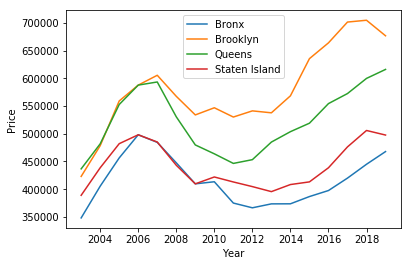

In [38]:
borough_years = np.empty((0, 5), int)
for year in range(2003, 2020):
    borough_years = np.append(borough_years, [house_sales[house_sales['SALE DATE'].str.contains(str(year))]\
                                     .groupby(['BOROUGH'])['SALE PRICE'].median().values], axis=0)
    
borough_years = np.delete(borough_years, (2), axis=1)
for borough in borough_years.T:
    plt.plot([year for year in range(2003, 2020)], borough)
    
plt.ylabel('Price')
plt.xlabel('Year')
plt.legend(['Bronx', 'Brooklyn', 'Queens', 'Staten Island'])
plt.show()

The decline toward the center is very likely due to the housing market crash. Otherwise, this is a promising start. Every borough seems to have had an overall increase in residential sale price which warrants checking to see if a greater number of alterations plays a part.

Now I want to check a couple of years to see what a simple scatter plot with the number of permits vs. median price looks like. Let's assume the lag time is one year for now. The much pricier zip codes will throw off the scale, but should still be able to see some direction.

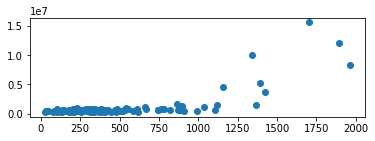

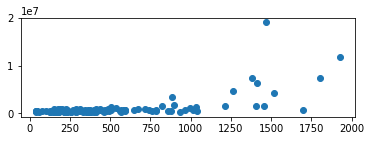

In [16]:
corr_df = combined_df.reset_index()
corr_df = corr_df[corr_df['Zip Code'].isin(corr_df['Zip Code'].value_counts()\
                                           [corr_df['Zip Code'].value_counts()==17].index)]

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(2, 1, 1)
ax.scatter(corr_df[corr_df['Year'] == 2013]['Total'], corr_df[corr_df['Year'] == 2014]['Median Price'])

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(2, 1, 2)
ax.scatter(corr_df[corr_df['Year'] == 2014]['Total'], corr_df[corr_df['Year'] == 2015]['Median Price'])

plt.show()

Now for some geospatial visualization

In [17]:
zips = gpd.read_file("data/NYC_Zip_Codes/ZIP_CODE_040114.shp")
zips.geometry = zips.geometry.buffer(0)
zips = zips[['ZIPCODE', 'POPULATION', 'AREA', 'geometry']]
zips['ZIPCODE'] = zips['ZIPCODE'].astype(int)
zips.head()

,ZIPCODE,POPULATION,AREA,geometry
0,11436,18681.0,2.269930e+07,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,62426.0,2.963100e+07,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,83866.0,4.197210e+07,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,56527.0,2.369863e+07,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,72280.0,3.686880e+07,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [18]:
combined_df['Total'] = combined_df['Total'].astype(int)

Let's see the total number of permits per zip code

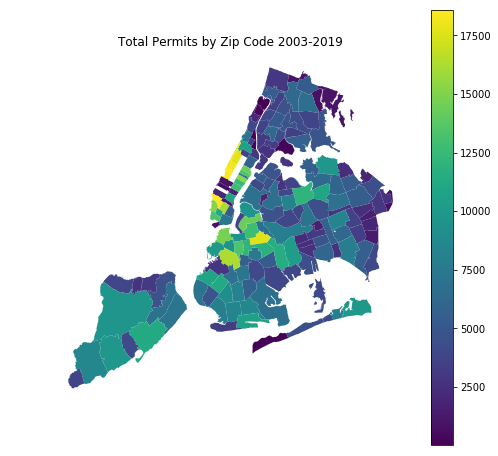

In [19]:
permits = combined_df.reset_index().groupby(['Zip Code']).sum().drop(columns=['Year'])
permits.reset_index(inplace=True)
pd.merge(zips, permits, how='inner', left_on=['ZIPCODE'], right_on=['Zip Code'])\
                                            .plot(column='Total', legend=True, figsize=(8,8))

plt.title('Total Permits by Zip Code 2003-2019')
plt.axis('off');

This geospatial map of the permits holds quite true to the housing prices, with Manhattan and Brooklyn having the most, Staten Island and Queens after, and then The Bronx.

## Analysis
Here I am going to first normalize the data before calculating cross correlation

In [21]:
from sklearn import preprocessing

corr_df['Total'] = preprocessing.StandardScaler().fit_transform(\
                                                corr_df['Total'].astype(np.float64).values.reshape(-1, 1))

corr_df['Median Price'] = preprocessing.StandardScaler().fit_transform(\
                                                corr_df['Median Price'].astype(np.float64).values.reshape(-1, 1))

Now I will be using cross correlation to detect how many years the permit data lags behind the house price data before a change is seen.

In [22]:
shifts = np.array([])
for zip_code in corr_df['Zip Code'].unique():
    corr = np.correlate(corr_df[corr_df['Zip Code'] == zip_code]['Total'].values, \
              corr_df[corr_df['Zip Code'] == zip_code]['Median Price'].values, mode='full')
    
    shifts = np.append(shifts, np.argmax(corr) - 16)
    
shifts.mean()

3.2734375

According to the cross correlation, it takes 3.27 years on average to see the effects alterations have on residential listing prices.

Now going off the assumption that a greater correlation between alterations and pricing means greater gentrification, let's see which areas are affected the most.

In [35]:
from scipy import stats

affected_zips = pd.DataFrame(columns=['Zip Code', 'r'])
i = 0
for zip_code in corr_df['Zip Code'].unique():
    totals = corr_df[(corr_df['Zip Code'] == zip_code) & \
                     (corr_df['Year'] < 2017)]['Total'].values
    medians = corr_df[(corr_df['Zip Code'] == zip_code) & \
                      (corr_df['Year'] > 2005)]['Median Price'].values
    
    r = stats.pearsonr(totals, medians)[0]
    affected_zips.loc[i] = [zip_code, r]
    
    i += 1
    
affected_zips['Zip Code'] = affected_zips['Zip Code'].astype(int)
affected_zips.sort_values(by=['r'], inplace=True, ascending=False)
print('The 5 most gentrified zip codes in the past 17 years are:\n', affected_zips[:5])

The 5 most gentrified zip codes in the past 17 years are:
     Zip Code         r
18     10314  0.844729
17     10312  0.832621
12     10306  0.812235
8      10302  0.809423
58     11217  0.789726


10314: Staten Island
<br>
10312: Staten Island
<br>
10306: Staten Island
<br>
10302: Staten Island
<br>
11217: Brooklyn

It seems as though Staten Island is most affected by gentrification in recent years. There are plenty of other zip codes with a high correlation, too, but it's safe to only consider the highest. New York City has had a slight increase in population which could affect some increase in pricing, but the correlation between alterations/new buildings and pricing is very convincing. Without access to population change year over year, it's difficult to distinguish the details.

### Going Further
The next steps I will take are to see how accurately I can predict future prices based on the number of different alterations and new buildings. This could easily be done using polynomial regression and may lead to some further discovery. I would also like to add another geospatial plot on the r-squared values of different zip codes to get a better understanding of which areas are greatly affected.